# <Gillespie simulation combining "pMHC binding - LAT nucleation - T-cell activation">

Version: latsim02_edit_freely \\
[Refer to the master version](https://colab.research.google.com/drive/1cs49PDxbP_Ac83jh84h4xfowCZYF6SbN?usp=sharing)

Created by: Neil H Kim

![ref](https://i.imgur.com/gfRofsE.png)

![ref](https://i.imgur.com/8n7tNzF.png)

* Use policy \\
. Any Groves Lab person can comment/edit this notebook. \\
. Do not worry about messing things up because the original version is stored in my [github repository](https://github.com/neilhkim/LATsim01). 

* Future works \\
Major: \\
. ~~Include LAT condensate lifetime.~~ \\
. ~~Include models of information integration~~  \\
. ~~Count cooccurring LAT condensates~~ \\
. ~~Make the hard-threshold value as an input option.~~ \\
. P15 vs. k_off graph (req: Sungi) \\
. ~~Make the hard-threshold version faster~~ \\
. ~~Apply probabilistic activation per max nLAT (bootstrap). Since we generate the whole trajectory first, this is doable.~~ \\
. ~~Draw Response function (Prob_activation vs. kbind) with different kunbind. (req: Sungi)~~ \\
 . Find out which parameter changes the steepness of the response curve. (req: Sungi)




# **Package imports, graph setups, and function definitions**
(You may skip reading this part and go to the next) \\
(However, you must run this part before running the following parts.)

In [ ]:
#@title

import random
from tracemalloc import stop
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from csv import writer 
import pandas as pd
import itertools
import sys
from ipywidgets import FloatProgress, IntProgress
from IPython.display import display
import datetime

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2


def LAT_formation_func(t):
    ret = 0.3 * stats.gamma.pdf(t, a=4, scale=7) #a=2.86, scale=7.03 for pMHC a=2.52, scale=10.48 for CD80
    return ret

def calc_propensities(pMhcLifeTimes, kbind, kunbind):
    # Three scenarios - 0) new pMHC binds, 1) bound pMHC unbinds, 2) bound pMHC forms LAT
    nBoundPMhc = pMhcLifeTimes.size
    propensities = np.array([]) 
    propensities = np.append(propensities, kbind)  # Scenario 0)
    propensities = np.append(propensities, kunbind * nBoundPMhc) # Scenario 1)
    if pMhcLifeTimes.size > 0: # Scenario 2)
        for t in np.nditer(pMhcLifeTimes):
            #########################################################################################
            LAT_assembly_rate = LAT_formation_func(t)
            #########################################################################################
            propensities = np.append(propensities, LAT_assembly_rate)
    return propensities

def sample_discrete(probs):
    # Generate random number
    q = np.random.rand()
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, pMhcLifeTimes, args=()):
    # Compute propensities
    calc_propensities = propensity_func(pMhcLifeTimes, *args)
    # Sum of propensities
    props_sum = calc_propensities.sum()
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    # Compute discrete probabilities of each reaction
    rxn_probs = calc_propensities / props_sum
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    return rxn, time

def gillespie_ssa(propensity_func, time_points, args=(), nLATthreshold=3,early_termination_option=False, stop_at_current_lat_n=100):
    # Initialize output
    nSpecies = 2
    pop_out = np.empty((len(time_points), nSpecies), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    nTimepoints = time_points.size
    boundPMhcIndices = np.array([])
    pMhcLifeLog = np.array([])
    '''
    pMhcLifeLog[0].size == time_points.size 
    (Examples)
    pMhcLifeLog[i] (non-productive life) : [0, 0, 0, 0, 0, 0, np.nan, np.nan, ..., np.nan] : {bound, unbind}
    pMhcLifeLog[j] (producctive life)    : [0, 0, 1, 1, 1, 1,  np.nan, np.nan, ... np.nan] : {bound, produce, unbind}
    '''
    pMhcLifeTimes = np.array([])
    pMhcLifeTimes = np.reshape(pMhcLifeTimes, (-1,2)) # [index, lifetime]
    remainingLatLifeTimes = np.array([])
    remainingLatLifeTimes = np.reshape(remainingLatLifeTimes, (-1,2)) # [index, lifetime]
    nBoundPMhc = 0
    nLat = 0
    pop_out[0,:] = np.array([0, 0])

    pMhcIndex = int(0)
    latIndex = int(0)

    boundPMhcIndices = []
    productivePMhcIndices = []

    while i < len(time_points):
        while t < time_points[i_time]:

            population_previous = np.array([nBoundPMhc,nLat])

            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, pMhcLifeTimes[:,1], args) # event number also indicates the index of the pMhc that results in LAT condensation.

            if not isinstance(event, int):
                print('event is not integer')
                quit()    

            # Process which event happened.
            if event == 0: # new binding
                pMhcLifeTimes = np.append(pMhcLifeTimes, [pMhcIndex, 0])
                pMhcLifeTimes = np.reshape(pMhcLifeTimes, (-1,2))
                entry = np.empty(nTimepoints)*np.nan
                entry[0] = 0
                pMhcLifeLog = np.append(pMhcLifeLog, entry)
                pMhcLifeLog = np.reshape(pMhcLifeLog, (-1,nTimepoints))
                boundPMhcIndices.append(int(pMhcIndex))
                pMhcIndex += 1

            elif event == 1: # unbinding
                random_index = random.randrange(len(boundPMhcIndices))
                poppedPMhcId = int(boundPMhcIndices.pop(random_index))
                # randIdex = random.randrange(pMhcLifeTimes.size)
                # unbindingTimes = np.append(unbindingTimes, pMhcLifeTimes[randIdex])
                i = np.argwhere(pMhcLifeTimes[:,0]==poppedPMhcId)
                if len(i) > 1:
                    print('popped more than 1?')
                    quit()   
                pMhcLifeTimes = np.delete(pMhcLifeTimes, i, 0)                    

            else: # LAT condensation
                alpha, scale = 1.78, 1/0.0592
                selectLT = np.random.gamma(alpha, scale)
                addarray = np.array([latIndex, selectLT])
                remainingLatLifeTimes = np.append(remainingLatLifeTimes, addarray)
                remainingLatLifeTimes = np.reshape(remainingLatLifeTimes, (-1,2))
                latIndex += 1
                prodIdxAmongLifeTimes = event - 2  # event number 2, 3, ... means LAT condensate producing pMHC's index is 0, 1, ...
                productivePMhcIndices.append(int(pMhcLifeTimes[prodIdxAmongLifeTimes,0]))
                pMhcLifeTimes = np.delete(pMhcLifeTimes,prodIdxAmongLifeTimes, axis=0) 

            nBoundPMhc = len(boundPMhcIndices)
            
            # Increment time
            pMhcLifeTimes[:,1] += dt
            remainingLatLifeTimes[:,1] -= dt
            subZeroIdx = np.argwhere(remainingLatLifeTimes[:,1] < 0)
            remainingLatLifeTimes = np.delete(remainingLatLifeTimes, subZeroIdx, axis=0) 
            t += dt
            nLat = len(remainingLatLifeTimes)

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        pop_out[i_time:min(i,len(time_points))] = population_previous
        if early_termination_option:
          if nLat >= nLATthreshold:
              pop_out[i:len(time_points)] = [-1, nLat]
              break;
        if nLat >= stop_at_current_lat_n:
              pop_out[i:len(time_points)] = [-1, nLat+10]
              break;

        bNotP_indices = [item for item in boundPMhcIndices if item not in productivePMhcIndices]
        bAndP_indices = [item for item in boundPMhcIndices if item in productivePMhcIndices]
        bNotP_indices = [int(x) for x in bNotP_indices]
        bAndP_indices = [int(x) for x in bAndP_indices]

        for x in bNotP_indices:
            earlistNanPosition = np.where(np.isnan(pMhcLifeLog[x]))[0][0]
            pMhcLifeLog[x,earlistNanPosition:earlistNanPosition+i-i_time] = int(0)

        for x in bAndP_indices:
            earlistNanPosition = np.where(np.isnan(pMhcLifeLog[x]))[0][0]
            pMhcLifeLog[x,earlistNanPosition:earlistNanPosition+i-i_time] = int(1)

        # Increment index
        i_time = i
  
    return pop_out, pMhcLifeLog

def calc_activation_prob(x):
    # x^4.28/(x^4.28 + 3^4.28)
    K = 4.28
    EC50 = 2
    prob = x ** K / (x ** K + EC50 ** K)
    return prob

def run(
    ligand_densities = [.01, .05, .1, .3, .5], 
    kunbind_list = [0.042, 0.11], 
    nCell = 1, 
    endtime = 200, 
    nTimePoints = 100, 
    n_P_act_estimation = 1,
    nLATthreshold = 3,
    plotTimeTraces = False,
    plotResponseCurve = False,
    early_termination_option = False,
    probabilistic_activation = False,
    make_output_files = False,
    stop_at_current_lat_n = 100,
    outputname = ''
    ):

    if probabilistic_activation and early_termination_option:
        sys.exit("probabilistic_activation and early_termination_option cannot both be True.")

    # The known kunbind of MCC is 0.042/s and T102S is 0.11/s
    # np.random.seed(51) # Seed random number generator for reproducibility
    time_points = np.linspace(0, endtime, nTimePoints)
    LIGAND_DENSITY_TO_KBIND_FACTOR = 1.3 # Measured by Darren and Mark.
    kbind_list = [ld * LIGAND_DENSITY_TO_KBIND_FACTOR for ld in ligand_densities]
    df = pd.DataFrame(columns = ['kunbind', 'kbind', 'ligand_density', 'prob_activate', 'nCell'])
    for kunbind in kunbind_list:
        print(f'\n================ LIGAND:  kunbind = {kunbind} / s')
        for kbind in kbind_list:
            # df = pd.DataFrame()
            args = (kbind, kunbind)
            # Initialize output array
            samples = np.empty((nCell, len(time_points), 2), dtype=int)
            pMhcLifeLogs = np.array([])
            print(f'\n~~~ kunbind = {kunbind} / s, ligand density = {kbind/LIGAND_DENSITY_TO_KBIND_FACTOR:.3f} / um2')
            
            
            status = f'ligand: {kunbind}/s density: {kbind/LIGAND_DENSITY_TO_KBIND_FACTOR:.3f}/um2'
            progbar = IntProgress(
                      min=0, max=nCell, 
                      description=f'{nCell} cells',
                      ) # instantiate the bar

            print(status)
            display(progbar)
            for j in range(n_P_act_estimation):
                nActivated = 0
                progbar.value = 0
                for i in range(nCell):
                    progbar.value += i
                    samples[i,:,:], temp = gillespie_ssa(
                                                          calc_propensities, time_points, args=args, 
                                                          nLATthreshold=nLATthreshold, early_termination_option=early_termination_option, 
                                                          stop_at_current_lat_n=stop_at_current_lat_n
                                                         )
                    pMhcLifeLogs = np.append(pMhcLifeLogs, temp)
                    pMhcLifeLogs = np.reshape(pMhcLifeLogs, (-1,len(time_points)))
                    
                    # Decision making mechanism (e.g., nLAT>=3)
                    max_nLAT = max(samples[i,:,1])
                    if probabilistic_activation:
                        if np.random.rand() < calc_activation_prob(max_nLAT):
                            nActivated += 1
                    else:
                        if max_nLAT >= nLATthreshold:
                            nActivated += 1
                prob_activate = nActivated / nCell
                ligand_density = kbind / LIGAND_DENSITY_TO_KBIND_FACTOR
                print(f'>>> P_act(nCell={nCell}): {prob_activate}')
                df = pd.concat([df, pd.DataFrame.from_records(
                    [{
                    'kunbind' : kunbind, 
                    'kbind' : kbind, 
                    'ligand_density' : ligand_density, 
                    'prob_activate' : prob_activate, 
                    'nCell' : nCell
                    }]
                    )],
                    ignore_index = True,
                )

                if plotTimeTraces:
                    countmsg = f'n_pMHC={len(pMhcLifeLogs)}, n_Cell={nCell}'
                    fig, axs = plt.subplots(1,3, figsize=(12, 3))
                    j = 0
                    x = time_points
                    y = pMhcLifeLogs
                    axs[j].plot(x, sum(~np.isnan(y)), linewidth=2, color='black')
                    axs[j].xaxis.set_tick_params(direction='in')
                    axs[j].yaxis.set_tick_params(direction='in')
                    axs[j].set_xlabel('Dwell time (s)')
                    axs[j].set_ylabel('Count')
                    axs[j].set_title('pMHC dwell time distribution')
                    axs[j].set_yscale('log')
                    plt.text(0.9, 0.9, countmsg, ha='right', va='top', transform=axs[j].transAxes)
                    for i in [0, 1]:
                        j = i + 1
                        for timetrace in samples[:,:,i]: # x is each trial sequence
                            axs[j].plot(time_points, timetrace, linewidth=2, alpha=.7, color='gray')
                        axs[j].plot(time_points, samples[:,:,i].mean(axis=0), linewidth=2, alpha=.6, color='orange')
                        axs[j].xaxis.set_tick_params(direction='in')
                        axs[j].yaxis.set_tick_params(direction='in')
                        axs[j].set_xlabel('Time (s)')
                        axs[j].set_ylabel('Count')
                    axs[1].set_title('Number of bound pMHC')
                    axs[2].set_title('Number of LAT condensates')
                    # fig.suptitle(countmsg, fontsize = 10)
                    plt.show()
    print()
    print(df)
    print()
    if make_output_files:
      if outputname == '':
        outputname = str(datetime.datetime.now())
        outputname = outputname.replace(':', '_')
      df.to_csv(f'{outputname}.csv')


    if plotResponseCurve:
        n_kunbinds = len(kunbind_list)
        fig, ax = plt.subplots(figsize=(5,3))
        palette = itertools.cycle(sns.color_palette('husl',n_kunbinds))
        ax.set_prop_cycle('color',[plt.cm.Pastel2(i) for i in np.linspace(0, 1, n_kunbinds)])
        labels = [(r'$k_{unbind}:$' + f'{k}' + '/s') for k in kunbind_list]

        for i in range(n_kunbinds):
            dfsub = df.loc[df['kunbind'] == kunbind_list[i]]
            sns.lineplot(data=dfsub, x='ligand_density', y='prob_activate', ci='sd', err_style='bars', 
                marker='o', markersize=8, linewidth=2,
                color=next(palette),
                label=labels[i]
                )
        ax.set(xscale='log')
        ax.set_xlabel(r'$Density_{pMHC}(/um2)$', labelpad=10)
        ax.set_ylabel(r'$P_{activate}$', labelpad=10)
        ax.legend(frameon=False, fontsize=12, loc="upper left")
        fig.suptitle('Activation probability Vs. pMHC surface density\n', fontsize=12,)
        plt.xscale('log')
        if make_output_files:
          if outputname == '':
            outputname = str(datetime.datetime.now())
            outputname = outputname.replace(':', '_')
          plt.savefig(f'{outputname}.png', dpi=300, transparent=False, bbox_inches='tight')
          plt.savefig(f'{outputname}.pdf', transparent=True, bbox_inches='tight')
        plt.show()


def draw_LATc_propensity():
    x = np.linspace(0, 100, 100)
    y = [LAT_formation_func(s) for s in x]
    fig = plt.figure(figsize=(5, 2)) # The unit is inches
    ax = fig.add_axes([0.2, 0.2, 0.6, .6]) # This unit is percentage
    ax.plot(x, y, 
            color='cornflowerblue', 
            # label=f'0.3 * stats.gamma.pdf\n(t, a={a}, scale={scale})', 
            linewidth=3,
            )
    ax.set_title('LAT formation propensity', fontsize=14,)
    ax.set_xlabel(r'bound time (s)', labelpad=10)
    ax.set_ylabel(r'$P_{LAT}$', labelpad=10)
    ax.legend(frameon=False, fontsize=9, loc='upper right')
    plt.show()

# **Plot the LAT condensation propensity function (optional)** 
Check the LAT formation propensity being used.

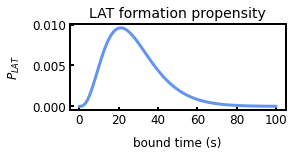

In [ ]:
draw_LATc_propensity()

McAffee et al. bioRxiv (2021)
is a good match with the gamma distribution pdf of alpha=2, theta=14. \\
![ref](https://i.imgur.com/ZmP3C5x.png)![ref](https://i.imgur.com/aktke9i.png) 



# **Simulate a T-cell (optional)** 
plotTimeTraces = True


================ LIGAND:  kunbind = 0.11 / s

~~~ kunbind = 0.11 / s, ligand density = 1.000 / um2
ligand: 0.11/s density: 1.000/um2


IntProgress(value=0, description='1 cells', max=1)

>>> P_act(nCell=1): 0.0


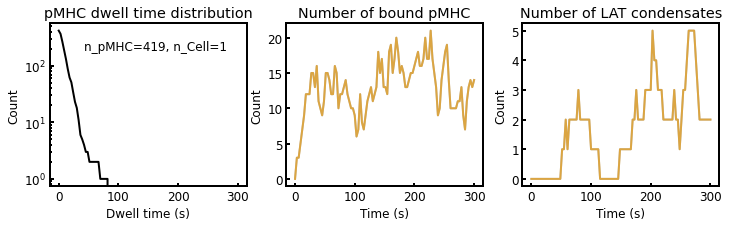


   kunbind  kbind  ligand_density  prob_activate nCell
0     0.11    1.3             1.0            0.0     1



In [ ]:
run(
    ligand_densities = [1], 
    kunbind_list = [0.11], 
    endtime=300, 
    plotTimeTraces=True, 
    nLATthreshold=1000, 
    early_termination_option=False,
    probabilistic_activation=False,
    stop_at_current_lat_n=100
    )

# **Simulate over a range of ligand_densities and pMHCs (the main test)**
MCC k_unbind = 0.042/s \\
T102S k_unbind = 0.11/s \\
plotResponseCurve = True

In [ ]:
run(
      ligand_densities = [100],#[0.001, 0.01, 0.03, 0.1, 0.2, 0.3, 0.7, 1],
      kunbind_list = [1.1],#[0.01, 0.05, 0.1, 0.3, 1], #[3.3, 1.1], #[[3.5, 1.1, 0.35, 0.11, 0.042, 0.035, 0.011, 0.0035]], 
      nCell = 1, 
      n_P_act_estimation= 100,
      # nLATthreshold = 5, 
      endtime=300, 
      plotResponseCurve=True, 
      probabilistic_activation=True,
      early_termination_option=False,
      make_output_files=True,
      stop_at_current_lat_n=10,
      outputname = 'a=5, shape=5.6',
    )


================ LIGAND:  kunbind = 1.1 / s

~~~ kunbind = 1.1 / s, ligand density = 100.000 / um2
ligand: 1.1/s density: 100.000/um2


IntProgress(value=0, description='1 cells', max=1)

>>> P_act(nCell=1): 0.0
>>> P_act(nCell=1): 0.0
>>> P_act(nCell=1): 1.0
>>> P_act(nCell=1): 0.0
>>> P_act(nCell=1): 1.0
>>> P_act(nCell=1): 0.0
>>> P_act(nCell=1): 1.0


KeyboardInterrupt: ignored